*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

# In Depth: k-Means Clustering

In the previous few sections, we have explored one category of unsupervised machine learning models: dimensionality reduction.
Here we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

We begin with the standard imports:

In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.cluster import KMeans
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

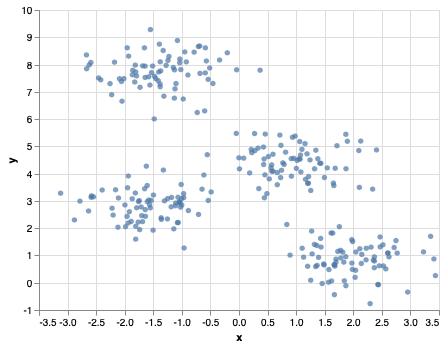

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
data = pd.DataFrame(X, columns=['x', 'y'])
chart1 = alt.Chart(data).mark_circle().encode(x='x', y='y')
chart1

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [3]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
data['cluster'] = y_kmeans
data.head()

,x,y,cluster
0,0.836857,2.136359,2
1,-1.413658,7.409623,1
2,1.155213,5.099619,0
3,-1.018616,7.814915,1
4,1.271351,1.892542,2


Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

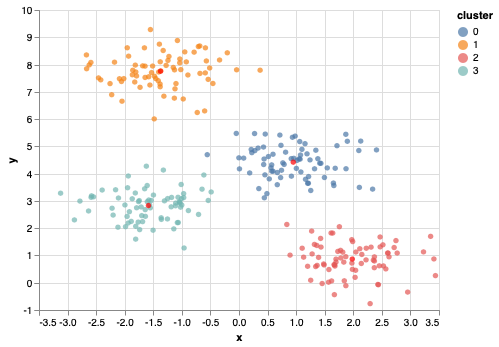

In [4]:
centers = kmeans.cluster_centers_
chart1 = alt.Chart(data).mark_circle().encode(x='x', y='y', color='cluster:N')
chart2 = alt.Chart(pd.DataFrame(centers, columns=['x', 'y'])).mark_circle(color='red').encode(x='x', y='y')
chart1 + chart2

## k-Means Algorithm: Expectation–Maximization

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

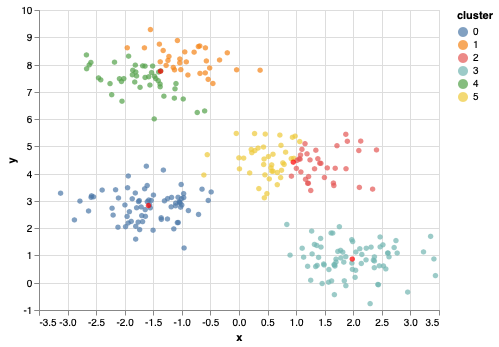

In [5]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
data['cluster'] = y_kmeans
chart1 = alt.Chart(data).mark_circle().encode(x='x', y='y', color='cluster:N')
chart2 = alt.Chart(pd.DataFrame(centers, columns=['x', 'y'])).mark_circle(color='red').encode(x='x', y='y')
chart1 + chart2

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

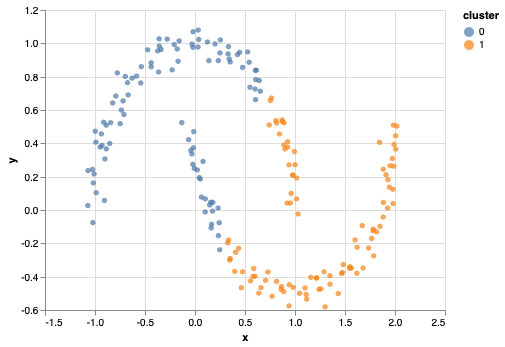

In [7]:
labels = KMeans(2, random_state=0).fit_predict(X)
data = pd.DataFrame(X, columns=['x', 'y'])
data['cluster']= labels
alt.Chart(data).mark_circle().encode(x='x', y='y', color='cluster:N')

/Users/hanisaf/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


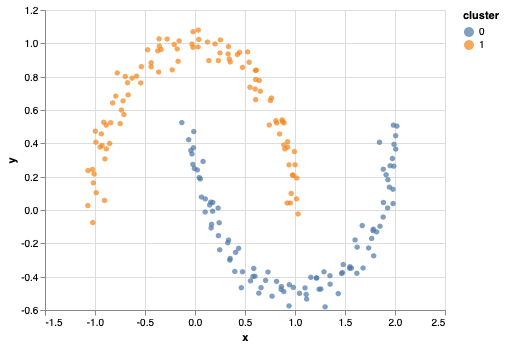

In [8]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
data = pd.DataFrame(X, columns=['x', 'y'])
data['cluster']= labels
alt.Chart(data).mark_circle().encode(x='x', y='y', color='cluster:N')

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``; we will see an example of its use as we continue our discussion.

## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a wide variety of situations.
We'll now take a look at a couple examples.

In [9]:
data=pd.read_json('data/cars.json').dropna()
data['Year'] = data['Year'].str[:4].apply(int)
data.head()

,Acceleration,Cylinders,Displacement,Horsepower,Miles_per_Gallon,Name,Origin,Weight_in_lbs,Year
0,12.0,8,307.0,130.0,18.0,chevrolet chevelle malibu,USA,3504,1970
1,11.5,8,350.0,165.0,15.0,buick skylark 320,USA,3693,1970
2,11.0,8,318.0,150.0,18.0,plymouth satellite,USA,3436,1970
3,12.0,8,304.0,150.0,16.0,amc rebel sst,USA,3433,1970
4,10.5,8,302.0,140.0,17.0,ford torino,USA,3449,1970


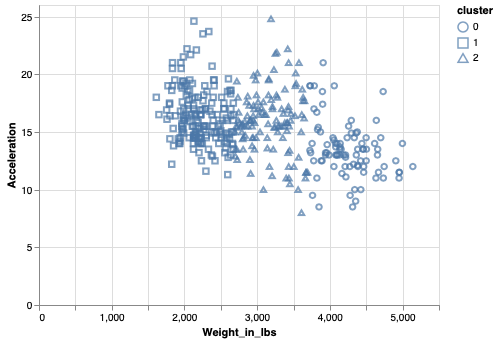

In [10]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data[['Weight_in_lbs', 'Acceleration']])
y_kmeans = kmeans.predict(data[['Weight_in_lbs', 'Acceleration']])
data['cluster'] = y_kmeans
alt.Chart(data).mark_point().encode(x='Weight_in_lbs', y='Acceleration', shape='cluster:N')


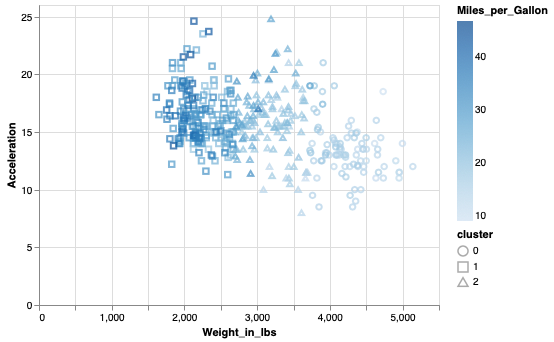

In [11]:
alt.Chart(data).mark_point().encode(x='Weight_in_lbs', y='Acceleration', shape='cluster:N', color='Miles_per_Gallon')



In [12]:
data.groupby('cluster')['Miles_per_Gallon'].mean()

cluster
0    14.631461
1    29.688827
2    20.760484
Name: Miles_per_Gallon, dtype: float64